In [1]:
#Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import string
from os import path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import SimpleRNN,Dense,LSTM,Dropout,GRU,Bidirectional
from keras import regularizers

Using TensorFlow backend.


# Reading the Data
Reading individual lines from file and tag its particular sentiment.<br/>
The data is futher added to a dataframe for further manipulation

In [2]:
#Function to read the data
def read_files(data,type_of_data):
    with open(data,'rb') as file_to_read:
        sentences = file_to_read.readlines()
    sentences = [sentence.strip().decode('iso8859-1') for sentence in sentences]
    sentiment = [type_of_data] * len(sentences)
    sentences_df = pd.DataFrame(list(zip(sentences, sentiment)), columns =['reviews', 'sentiment'])
    return sentences_df

In [3]:
positive_reviews = read_files('rt-polaritydata/rt-polarity.pos',1)
negative_reviews = read_files('rt-polaritydata/rt-polarity.neg',0)
reviews = positive_reviews.append(negative_reviews).reset_index(drop=True)
assert len(positive_reviews) + len(negative_reviews) == len(reviews)

In [4]:
reviews.head()

,reviews,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
reviews      10662 non-null object
sentiment    10662 non-null int64
dtypes: int64(1), object(1)
memory usage: 166.7+ KB


In [6]:
reviews = shuffle(reviews).reset_index(drop=True)

In [7]:
reviews.head()

,reviews,sentiment
0,an unsophisticated sci-fi drama that takes its...,0
1,the film doesn't really care about the thousan...,0
2,"the acting , costumes , music , cinematography...",1
3,"the stripped-down dramatic constructs , auster...",1
4,it strikes hardest when it reminds you how pe...,1


# Data Pre-Processing
An NLP library "Spacy" is used to pre-process the data<br/>
1. The sentences are first converted to tokens
2. The tokens are all converted to lower case and tokens with POS keywords that are not useful are removed
3. The tokens are lemmatized
4. Removed punctuations and stop words
5. Return the cleaned (pre-processed) sentence

In [8]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
pos_tokens_unused = ['NUM','SYM','PUNCT','X','SPACE']
def custom_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    tokens = nlp(sentence.strip())
    
    #Pre-processing of tokens
    tokens = [token for token in tokens if token.pos_ not in pos_tokens_unused]
        
    #Consider tokens that are not punctuations and if length of token is greater than 2 and if they are not stop words
    tokens = [ token.lower_ for token in tokens if token.lower_ not in punctuations and token.lower_ not in spacy_stopwords]
    
    # return preprocessed list of tokens
    return ' '.join(tokens)

In [9]:
reviews.reviews = reviews.reviews.apply(custom_tokenizer)

# Split the data into Train and testing sets
1. 60% of the data is used for training
2. 20% of the data is used for validation<br/>
Note: The train-val split is taken care during the model building process
3. 20% of the data is used for testing<br/>
Data Split is balanced using stratification

In [10]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews.reviews, reviews.sentiment, test_size=0.2, random_state=42, stratify=reviews.sentiment)

In [11]:
print("Number of Positive Training Examples : {}".format(len(y_train[y_train == 1])))
print("Number of Negative Training Examples : {}".format(len(y_train[y_train == 0])))
print("Number of Positive Test Examples : {}".format(len(y_test[y_test == 1])))
print("Number of Negative Test Examples : {}".format(len(y_test[y_test == 0])))

Number of Positive Training Examples : 4265
Number of Negative Training Examples : 4264
Number of Positive Test Examples : 1066
Number of Negative Test Examples : 1067


# Tokenizer
Use the Keras inbuilt tokenizer to get the list of tokens and mark out of vocabulary vectors as 'OOV'

In [12]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Glove Embedding
Download Glove vectors initially if not available and read the file with 300 dimensions to generate the word embedings<br/>
Note: Initally if the glove vectors are not available it may take a while to download and read the glove vectors.

In [13]:
#Get the GloVe vector word embeddings from Stanford NLP library
def generate_word_embeddings():
    if not path.exists('glove.6B.zip'):
        print('Please wait while the Global Vector Word Embeddings are being downloaded.')
        !wget http://nlp.stanford.edu/data/glove.6B.zip
        !unzip glove*.zip
    word_embeddings = {}
    with open('glove.6B.300d.txt',encoding = 'utf-8') as file:
        for line in file:
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            word_embeddings[word] = word_vectors
    return word_embeddings
word_embeddings = generate_word_embeddings()

# Generate Word Embeddings for the model
Use the tokens generated by the Keras tokenizer to create a embedding matrix of weights for the model<br/>
The dimensions of the model are : Length of word Vector * 300 ( The embedded word dimension)<br/>
If any word is not found in the Glove embedding vector make it 0

In [14]:
#Generating a Embedding matrix
def generate_embedding_matrix(word_embeddings):
    vocabulary_size = len(tokenizer.word_index)+1
    embedding_matrix = np.zeros((vocabulary_size, 300))
    for word, index in tokenizer.word_index.items():
        embedding_vector = word_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix,vocabulary_size

In [15]:
#Function to plot the Accuracy and Loss of the training and testing models
def generate_plot(model):
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('Model Accuracy (Train & Validation)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'], loc = 'best')
    plt.show()
    
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss(Train & Validation)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'], loc = 'upper left')
    plt.show()

Function that generates model based on the provided parameters

In [16]:
def generate_model(**kwargs):
    input_len = kwargs['input_length']
    rnn_units = kwargs['rnn_units']
    epochs = kwargs['epochs']
    learning_rate = kwargs['learning_rate']
    #Regularization
    if kwargs['regularizer'] == 'l1':
        regularizer = regularizers.l1(0.01)
    elif kwargs['regularizer'] == 'l2':
        regularizer = regularizers.l2(0.01)
    else:
        regularizer = None
    X_train_processed = tokenizer.texts_to_sequences(X_train)
    X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=input_len,truncating='pre')
    embedding_matrix,vocabulary_size = generate_embedding_matrix(word_embeddings)
    keras.backend.clear_session()
    model = Sequential()
    embedding_layer = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=input_len,trainable = False,mask_zero=True)
    model.add(embedding_layer)
    #Type of Model
    if kwargs['model_type'] == 'rnn':
        model.add(SimpleRNN(rnn_units,kernel_regularizer = regularizer))
    elif kwargs['model_type'] == 'lstm':
        model.add(LSTM(units=rnn_units,kernel_regularizer = regularizer))
    elif kwargs['model_type'] == 'gru':
        model.add(GRU(units=rnn_units,kernel_regularizer=regularizer))
    else:
        model.add(Bidirectional(LSTM(units=rnn_units,kernel_regularizer = regularizer)))
    #Dropout
    if kwargs['dropout'] == True:
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    adam_optimizer = optimizers.adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    model_history = model.fit(X_train_processed, y_train, batch_size=128, epochs=epochs, verbose=1,validation_split = 0.2)
    plot = generate_plot(model_history)
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/10
6823/6823 [==============================] - 9s 1ms/step - loss: 0.6296 - acc: 0.6358 - val_loss: 0.5402 - val_acc: 0.7315
Epoch 2/10
6823/6823 [==============================] - 8s 1ms/step - loss: 0.5017 - acc: 0.7585 - val_loss: 0.5382 - val_acc: 0.7321
Epoch 3/10
6823/6823 [==========================

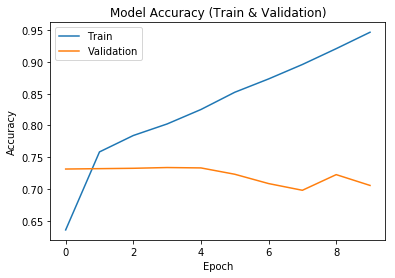

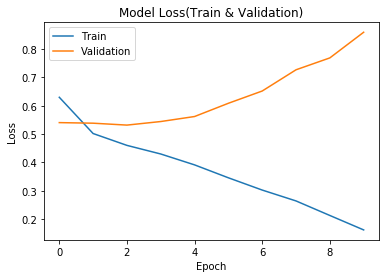

In [17]:
_ = generate_model(model_type='rnn',input_length = 150, regularizer = None, dropout = False,learning_rate = 0.001, rnn_units = 100,epochs=10)

# Type of Model: Vanilla RNN (1)<br/>
Length of Input sentence: 150<br/>
### Hyper Parameters:
1. Regularization: None <br/>
2. Dropout: None<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 10

### Observations
After a certain number of epochs the validation loss starts increasing reducing its accuracy. The model is overfitting the data. It starts learning training data features and does not generalize well on the unseen validation set. 

### Measures Taken

Early Stopping: Looking at the graph we can see that after 4 epochs the validation loss starts increasing, we can stop training the model at this stage and check the perfromance of the model.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/4
6823/6823 [==============================] - 9s 1ms/step - loss: 0.6293 - acc: 0.6425 - val_loss: 0.5448 - val_acc: 0.7198
Epoch 2/4
6823/6823 [==============================] - 9s 1ms/step - loss: 0.5028 - acc: 0.7538 - val_loss: 0.5600 - val_acc: 0.7181
Epoch 3/4
6823/6823 [=============================

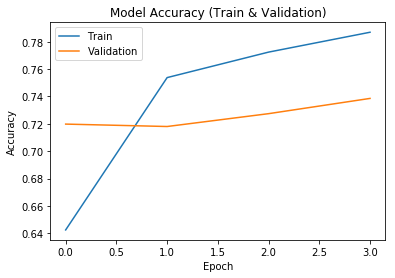

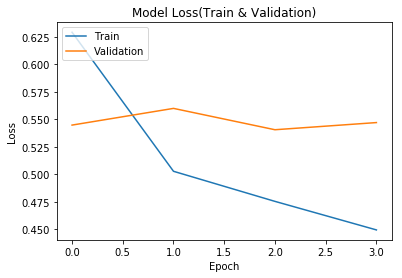

In [18]:
_ = generate_model(model_type='rnn',input_length = 150, regularizer = None, dropout = False,learning_rate = 0.001, rnn_units = 100,epochs=4)

# Type of Model: Vanilla RNN (2)<br/>
Length of Input sentence: 150<br/>
### Hyper Parameters:
1. Regularization: None <br/>
2. Dropout: None<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
Reducing the number of epochs still looks like the model is overfitting on training data.

### Measures Taken

Trying out a lower sequence length to see if it increases performance


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/4
6823/6823 [==============================] - 3s 482us/step - loss: 0.6212 - acc: 0.6496 - val_loss: 0.5273 - val_acc: 0.7321
Epoch 2/4
6823/6823 [==============================] - 3s 415us/step - loss: 0.5025 - acc: 0.7558 - val_loss: 0.5174 - val_acc: 0.7392
Epoch 3/4
6823/6823 [=========================

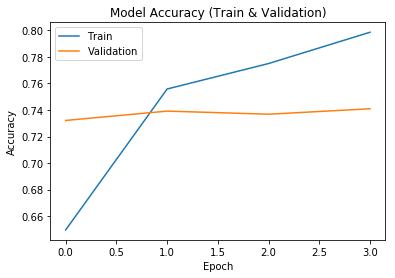

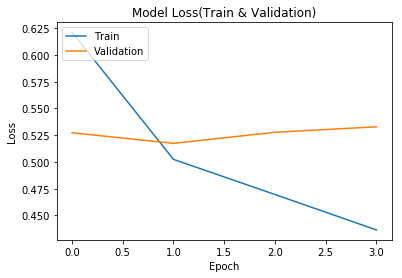

In [19]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = None, dropout = False,learning_rate = 0.001, rnn_units = 100,epochs=4)

# Type of Model: Vanilla RNN (3)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: None <br/>
2. Dropout: None<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
Reducing the length of the sequence showed an improved validation accuracy.

### Measures Taken

Trying out regularization to avoid overfitting.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/5
6823/6823 [==============================] - 3s 484us/step - loss: 12.5074 - acc: 0.6164 - val_loss: 6.8394 - val_acc: 0.6975
Epoch 2/5
6823/6823 [==============================] - 3s 432us/step - loss: 3.7337 - acc: 0.7117 - val_loss: 1.5211 - val_acc: 0.7016
Epoch 3/5
6823/6823 [========================

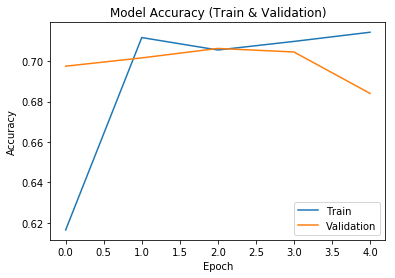

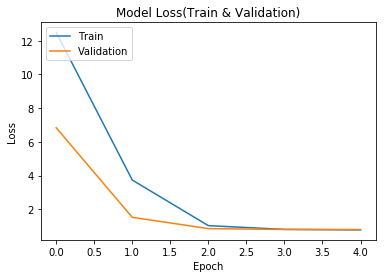

In [20]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l1', dropout = False,learning_rate = 0.001, rnn_units = 100,epochs=5)

# Type of Model: Vanilla RNN (4)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L1 <br/>
2. Dropout: None<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
L1 regualrization did perform well, it did not overfit on the training data, the loss seems to be gradually decreasing
### Measures Taken

Trying out regularization to avoid overfitting.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/5
6823/6823 [==============================] - 3s 485us/step - loss: 1.7443 - acc: 0.6273 - val_loss: 1.2923 - val_acc: 0.7427
Epoch 2/5
6823/6823 [==============================] - 3s 423us/step - loss: 1.0742 - acc: 0.7486 - val_loss: 0.9088 - val_acc: 0.7567
Epoch 3/5
6823/6823 [=========================

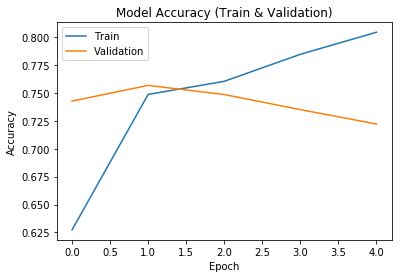

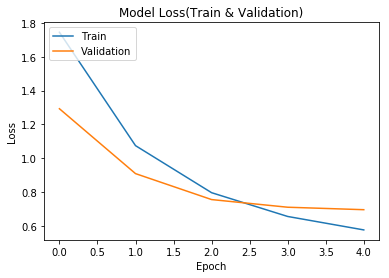

In [21]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l2', dropout = False,learning_rate = 0.001, rnn_units = 100,epochs=5)

# Type of Model: Vanilla RNN (5) <br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: None<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
L2 regualrization performed well than L1, it did not overfit on the training data, the loss seems to be gradually decreasing
### Measures Taken

Trying out dropout method to avoid overfitting. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/5
6823/6823 [==============================] - 3s 483us/step - loss: 0.6618 - acc: 0.6249 - val_loss: 0.5485 - val_acc: 0.7233
Epoch 2/5
6823/6823 [============================

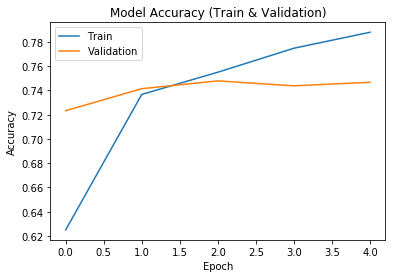

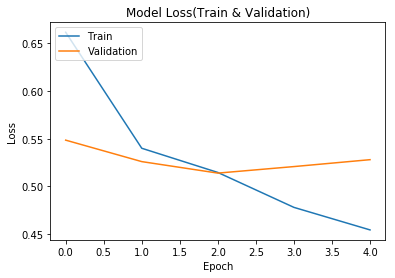

In [22]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = None, dropout = True,learning_rate = 0.001, rnn_units = 100,epochs=5)

# Type of Model: Vanilla RNN (6) <br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: None <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
Adding just the drop out for the RNN layer did not help improve the model score. The model worked well with the regualarization but not with the dropout.
### Measures Taken

Trying out Regularization + dropout and checking if the model performs better

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/4
6823/6823 [==============================] - 3s 486us/step - loss: 1.8550 - acc: 0.6232 - val_loss: 1.4305 - val_acc: 0.7309
Epoch 2/4
6823/6823 [============================

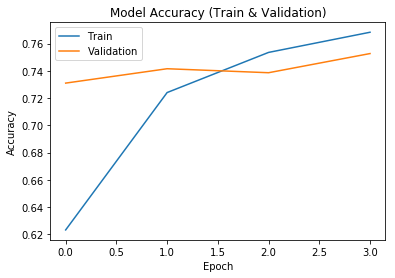

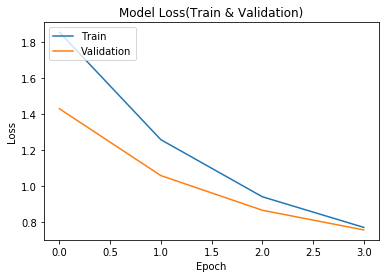

In [23]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.001, rnn_units = 100,epochs=4)

# Type of Model: Vanilla RNN (7)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
The model performs better after Regularized + Adding dropout. By adding a L2 regularizer, a drop out probability of 0.5 to the RNN layer, and early termination with 4 epochs has provided the best metrics so far
### Measures Taken

Trying with different learning rates

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/4
6823/6823 [==============================] - 3s 495us/step - loss: 4.0324 - acc: 0.5026 - val_loss: 1.9951 - val_acc: 0.5158
Epoch 2/4
6823/6823 [============================

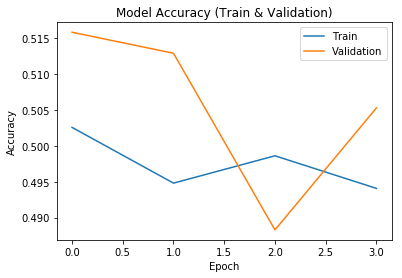

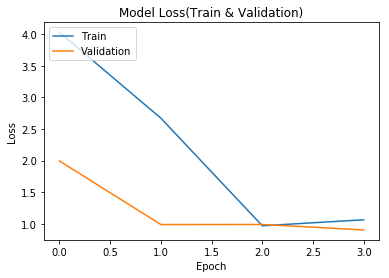

In [24]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.05, rnn_units = 100,epochs=4)

# Type of Model: Vanilla RNN (8)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.05<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 4

### Observations
Model with a higher learning rate, did not perfrom well, while finding the gradients, the gradient starts oscillating around the minimum because of a larger learning rate.
### Measures Taken
Trying to experiment with lower learning rate

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,884,001
Trainable params: 40,201
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/15
6823/6823 [==============================] - 3s 491us/step - loss: 2.2901 - acc: 0.4908 - val_loss: 2.1734 - val_acc: 0.5012
Epoch 2/15
6823/6823 [==========================

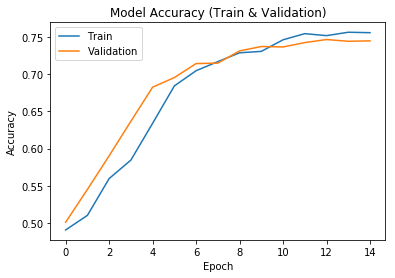

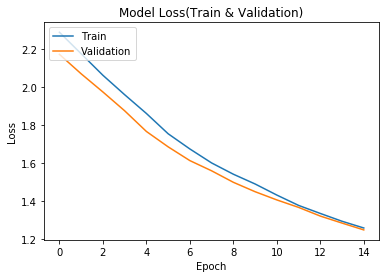

In [25]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.0001, rnn_units = 100,epochs=15)

# Type of Model: Vanilla RNN (9)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.0001<br/>
4. Number of hidding units in the main layer: 100<br/>
5. Number of Epochs: 15

### Observations
The model performed better with a lower learning rate, but the number of epochs had to be increased. This the model was run for 15 epochs and from the graph we can see that there is a steady increase in validation accuracy as well as loss is decreasing.
### Measures Taken
Trying to increase and/or decrease the number of units in the hidden layer.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 4,861,401
Trainable params: 17,601
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/15
6823/6823 [==============================] - 2s 364us/step - loss: 1.6495 - acc: 0.5029 - val_loss: 1.5541 - val_acc: 0.5340
Epoch 2/15
6823/6823 [==========================

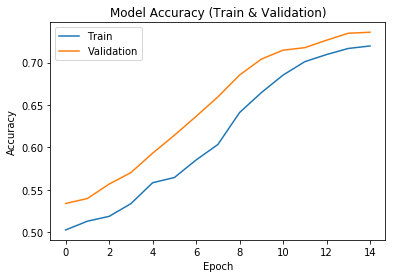

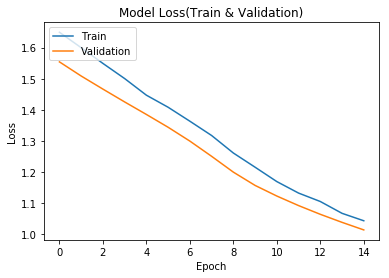

In [26]:
_ = generate_model(model_type='rnn',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.0001, rnn_units = 50,epochs=15)

# Type of Model: Vanilla RNN (10)<br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.0001<br/>
4. Number of hidding units in the main layer: 50<br/>
5. Number of Epochs: 15

### Observations
By reducing the number of units in the hidden layers to half the model perform almost the same as earlier model.
We will use the model with lesser number of hidden units this way it trains faster with lesser number of parameters

##### We willl consider the previous one as the best perform model with Vanilla RNN
#### Model Variant: Vanilla RNN
#### Number of hidden units: 50
Architecture: Input => Embedding(Glove, 600D) => SimpleRNN(100) => FullyConnected(1) => SigmoidActivation() => Output
#### Training Accuracy: 75.54%
#### Validation Accuracy: 74.44%

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 4,914,051
Trainable params: 70,251
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/30
6823/6823 [==============================] - 5s 678us/step - loss: 2.9598 - acc: 0.5317 - val_loss: 2.7922 - val_acc: 0.5662
Epoch 2/30
6823/6823 [==========================

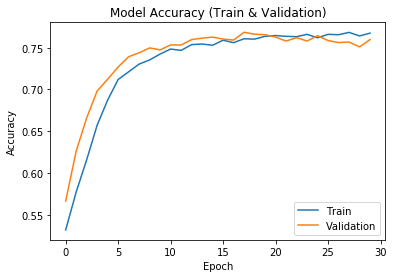

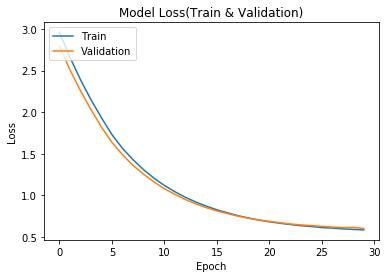

In [27]:
_ = generate_model(model_type='lstm',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.0001, rnn_units = 50,epochs=30)

# Type of Model: LSTM <br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.0001<br/>
4. Number of hidding units in the main layer: 50<br/>
5. Number of Epochs: 30

### Observations
The LSTM model implemented using same hyper-parameters as the RNN, provided an increased accuracy. The model was made to run for more epochs. Both the training and validation accuracy increased by using LSTM's

#### Model Variant: LSTM
#### Number of hidden units: 50
Architecture: Input => Embedding(Glove, 600D) => LSTM(50) => FullyConnected(1) => SigmoidActivation() => Output
#### Training Accuracy: 76.74%
#### Validation Accuracy: 75.97%

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                52650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 4,896,501
Trainable params: 52,701
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/30
6823/6823 [==============================] - 4s 631us/step - loss: 2.5939 - acc: 0.5071 - val_loss: 2.4569 - val_acc: 0.5545
Epoch 2/30
6823/6823 [==========================

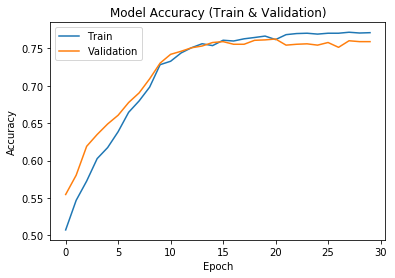

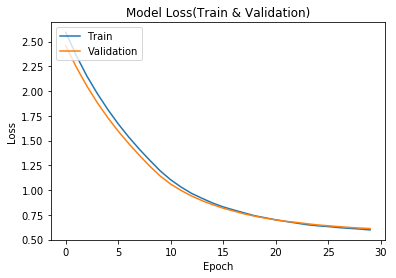

In [33]:
gru_model = generate_model(model_type='gru',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.0001, rnn_units = 50,epochs=30)

# Type of Model: GRU <br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.0001<br/>
4. Number of hidding units in the main layer: 50<br/>
5. Number of Epochs: 30

### Observations
Using the GRU model, there is an increased accuracy compared to the vanilla RNN. We can see a 2% increased in the accuracy with the same hyper parameters used.

#### Model Variant: GRU
#### Number of hidden units: 50
Architecture: Input => Embedding(Glove, 600D) => GRU(50) => FullyConnected(1) => SigmoidActivation() => Output
#### Training Accuracy: 76.92%
#### Validation Accuracy: 76.26%

Comparing the RNN, LSTM and GRU's, GRU has performed well on the validation set providing a accuracy of 76.26%<br/>
Trying out Bi-Directional RNN's with LSTM layer

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4843800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,984,301
Trainable params: 140,501
Non-trainable params: 4,843,800
_________________________________________________________________
None
Train on 6823 samples, validate on 1706 samples
Epoch 1/15
6823/6823 [==============================] - 7s 1ms/step - loss: 5.1851 - acc: 0.5410 - val_loss: 4.8520 - val_acc: 0.6032
Epoch 2/15
6823/6823 [===========================

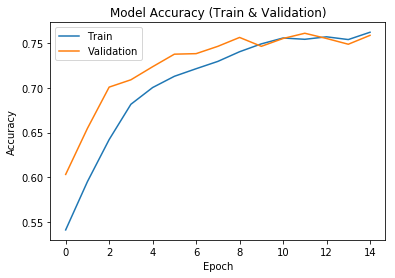

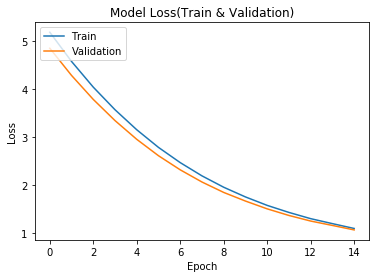

In [29]:
biDirectional_model = generate_model(model_type='biDirectional',input_length = 50, regularizer = 'l2', dropout = True,learning_rate = 0.0001, rnn_units = 50,epochs=15)

# Type of Model: Bi-Directional LSTM <br/>
Length of Input sentence: 50<br/>
### Hyper Parameters:
1. Regularization: L2 <br/>
2. Dropout: Yes<br/>
3. Learning Rate: 0.0001<br/>
4. Number of hidding units in the main layer: 50<br/>
5. Number of Epochs: 30

### Observations

#### Model Variant: Bi-Directional LSTM
#### Number of hidden units: 50
Architecture: Input => Embedding(Glove, 600D) => BiDirectional(LSTM((50))) => FullyConnected(1) => SigmoidActivation() => Output
#### Training Accuracy: 76.26%
#### Validation Accuracy: 75.91%

# Saving the GRU model as the best model, so that it can be used further for predictions.

In [34]:
#Load the best model and process the test data to make predictions
gru_model.save('best_model.h5')
best_model = tf.keras.models.load_model('best_model.h5')
X_test_processed = tokenizer.texts_to_sequences(X_test)
X_test_processed = pad_sequences(X_test_processed, padding='post', maxlen=50,truncating='pre')
best_model.evaluate(X_test_processed, y_test, verbose=1)

2133/2133 [==============================] - 1s 433us/sample - loss: 0.6380 - acc: 0.7464


[0.6379849217164925, 0.7463666]

In [35]:
#Predict the test data labels and use classification report to measure F-1 score
predictions = best_model.predict_classes(X_test_processed,verbose=1)
print(classification_report(y_test,predictions))

2133/2133 [==============================] - 1s 412us/sample
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1067
           1       0.72      0.80      0.76      1066

    accuracy                           0.75      2133
   macro avg       0.75      0.75      0.75      2133
weighted avg       0.75      0.75      0.75      2133



#### Precision:<br/> <br/>Class 0: 78% <br/> <br/> Class 1 : 72% <br/>
#### Recall:<br/> <br/>Class 0: 69% <br/> <br/> Class 1 : 80% <br/>
#### F-1 Score:<br/> <br/>Class 0: 73% <br/> <br/> Class 1 : 76% <br/>
### Weighted F-1 Score: 75%

### Final Observations
The LSTM's and GRU's almost provided the same performance, but we used GRU's as it is faster to train compared to LSTMS's

F-1 Score of 75% was recorded on the test data, given the data. This can be further improved by having more data for training the model, so more words can be analyzed to predict the sentiment

Because of the forget and control gates in LSTM and GRU, the models performed well compared to the Vanilla RNN which consideres the context of the entire input length of the data

I did try models with Glove vectors of 100D but the the model did not perform well on the validation set as compared to the 300D vectors